In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import dill
from tqdm import tqdm

import numpy as np
import pandas as pd

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

import hyperopt as hpo

import matplotlib.pyplot as plt
import seaborn as sns

from src import pipeline_utils as pipe
from src.config import data_folder, models_folder, seed, target, top, threshold
from src import utils

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [2]:
df_train = pd.read_csv(os.path.join(data_folder, 'train.tsv'), sep='\t')
df_test = pd.read_csv(os.path.join(data_folder, 'test.tsv'), sep='\t')

y_train = df_train[target]
y_test = df_test[target]

df_train = df_train.drop(columns=[target])
df_test = df_test.drop(columns=[target])

print('train', df_train.shape[0])
print('test ', df_test.shape[0])
print('feats', df_train.shape[1])

train 5215
test  1738
feats 26


In [3]:
json_list_cols = {
    'genres': 'name',
    'production_companies': 'name',
    'production_countries': 'name',
    'spoken_languages': 'iso_639_1',
    'Keywords': 'name',
    'crew': 'name',
    'cast': 'name',
}

one_hot_cols = [
    'original_language',
]

date_cols = [
    'release_date',
]

num_cols = [
    'budget',
    'popularity',
    'runtime',
    'video',
    'vote_average',
    'vote_count',
]

median_impute = [
    'runtime',
]

drop_cols = [
    'belongs_to_collection',
    'genres',
    'production_companies',
    'production_countries',
    'spoken_languages',
    'Keywords',
    'cast',
    'crew',
    'backdrop_path',
    'homepage',
    'id',
    'imdb_id',
    'original_title',
    'overview',
    'poster_path',
    'status',
    'tagline',
    'title',
    'release_date',
    'original_language'
]

eval_cols = [
    'belongs_to_collection',
    'genres',
    'production_companies',
    'production_countries',
    'spoken_languages',
    'Keywords',
    'cast',
    'crew',
]

top = 15
threshold = 100

In [4]:
pipeline = Pipeline(steps=[
    ('evaluator', FunctionTransformer(pipe.evaluator, kw_args={'feats': eval_cols})),
    ('Date_transformer', pipe.Date_transformer(date_cols)),
    ('Json_one_hot_encoder', pipe.Json_one_hot_encoder(json_list_cols, top=top, threshold=threshold)),
    ('One_hot_encoder', pipe.One_hot_encoder(one_hot_cols, top=top, threshold=threshold)),
#     ('column_selector', FunctionTransformer(pipe.column_selector, kw_args={'feats': num_cols})),
    ('column_dropper', FunctionTransformer(pipe.column_dropper, kw_args={'feats': drop_cols})),
    ('special_char_remover', FunctionTransformer(pipe.special_char_remover)),
    ('imputer', pipe.Imputer(median_impute, strategy='median')),
    ('floaterizer', FunctionTransformer(lambda x: x.astype(float))),
])

# pipeline.steps[1][1].values

In [5]:
%%time
pipeline.fit(df_train.copy())

X_train = pipeline.transform(df_train.copy())
X_test = pipeline.transform(df_test.copy())

assert X_train.isna().sum().sum() == 0

print('train', X_train.shape[0])
print('test ', X_test.shape[0])
print('feats', X_train.shape[1])

# X_train.describe(include='all').T.head(20)

train 5215
test  1738
feats 75
CPU times: user 21.3 s, sys: 258 ms, total: 21.6 s
Wall time: 21.5 s


In [12]:
xgb_space = {
    'model_type':              'xgb',  # ['xgb', 'cat', 'lgb']
    'n_estimators':            hpo.hp.quniform('n_estimators', low=6, high=13, q=1),  # 2 ** n
    'max_depth':               hpo.hp.quniform('max_depth', low=3, high=8, q=1),
    'learning_rate':           hpo.hp.uniform('learning_rate', low=0, high=8),  # 10 ** -(n/2)
    'verbosity':               0,
    'objective':               'reg:squaredlogerror',  # reg:squarederror
    'booster':                 hpo.hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'gamma':                   hpo.hp.uniform('gamma', low=1, high=11),  # 10 ** -(n/2)
    'min_child_weight':        hpo.hp.quniform('min_child_weight', low=1, high=3, q=1),
    'max_delta_step':          hpo.hp.quniform('max_delta_step', low=0, high=2, q=1),
    'subsample':               hpo.hp.uniform('subsample', low=0, high=1),
    'colsample_bytree':        hpo.hp.uniform('colsample_bytree', low=0.7, high=1),
    'colsample_bylevel':       hpo.hp.uniform('colsample_bylevel', low=0.7, high=1),
    'colsample_bynode':        hpo.hp.uniform('colsample_bynode', low=0.7, high=1),
    'reg_alpha':               hpo.hp.uniform('reg_alpha', low=0, high=1),
    'reg_lambda':              hpo.hp.uniform('reg_lambda', low=3, high=11),  # 10 ** -(n/2),
    'random_state':            seed,
    'num_parallel_tree':       hpo.hp.quniform('num_parallel_tree', low=1, high=3, q=1),
#     'tree_method':             'auto',  # hpo.hp.choice('tree_method', ['auto', 'exact', 'approx', 'hist', 'gpu_hist'])
#     'n_jobs':                  -1,
#     'scale_pos_weight':        1,
#     'base_score':              0.5,
#     'missing':                 np.nan,
#     'monotone_constraints':    '()',
#     'interaction_constraints': '',
#     'importance_type':         'gain',
#     'gpu_id':                  -1,
#     'validate_parameters':     1,
}

In [14]:
trainer = utils.HyperoptTrainer(model_type='xgb',
                              model_name='xgb_1',
                              X_train=X_train,
                              y_train=y_train,
                              X_test=X_test,
                              y_test=y_test,
                              models_path=models_folder,
                              seed=seed)


In [15]:
trainer.fmin(xgb_space, max_evals=500, prints=False)

  0%|          | 2/500 [00:09<38:10,  4.60s/trial, best loss: 6.483427310801698]


KeyboardInterrupt: 

In [12]:
xgb_space = {
    'model_type':              'xgb',  # ['xgb', 'cat', 'lgb']
    'n_estimators':            hpo.hp.quniform('n_estimators', low=6, high=13, q=1),  # 2 ** n
    'max_depth':               hpo.hp.quniform('max_depth', low=3, high=8, q=1),
    'learning_rate':           hpo.hp.uniform('learning_rate', low=0, high=8),  # 10 ** -(n/2)
    'verbosity':               0,
    'objective':               'reg:squaredlogerror',  # reg:squarederror
    'booster':                 hpo.hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'gamma':                   hpo.hp.uniform('gamma', low=1, high=11),  # 10 ** -(n/2)
    'min_child_weight':        hpo.hp.quniform('min_child_weight', low=1, high=3, q=1),
    'max_delta_step':          hpo.hp.quniform('max_delta_step', low=0, high=2, q=1),
    'subsample':               hpo.hp.uniform('subsample', low=0, high=1),
    'colsample_bytree':        hpo.hp.uniform('colsample_bytree', low=0.7, high=1),
    'colsample_bylevel':       hpo.hp.uniform('colsample_bylevel', low=0.7, high=1),
    'colsample_bynode':        hpo.hp.uniform('colsample_bynode', low=0.7, high=1),
    'reg_alpha':               hpo.hp.uniform('reg_alpha', low=0, high=1),
    'reg_lambda':              hpo.hp.uniform('reg_lambda', low=3, high=11),  # 10 ** -(n/2),
    'random_state':            seed,
    'num_parallel_tree':       hpo.hp.quniform('num_parallel_tree', low=1, high=3, q=1),
#     'tree_method':             'auto',  # hpo.hp.choice('tree_method', ['auto', 'exact', 'approx', 'hist', 'gpu_hist'])
#     'n_jobs':                  -1,
#     'scale_pos_weight':        1,
#     'base_score':              0.5,
#     'missing':                 np.nan,
#     'monotone_constraints':    '()',
#     'interaction_constraints': '',
#     'importance_type':         'gain',
#     'gpu_id':                  -1,
#     'validate_parameters':     1,
}


def objective(space):
    space = dict(sorted(list(space.items()), key=lambda x: x[0]))
    space_values = list(space.values())
    model_type = space.pop('model_type')

    if model_type == 'xgb':
        model = make_xgb_model(space)
    elif model_type == 'cat':
        model = make_cat_model(space)
    elif model_type == 'lgb':
        model = make_lgb_model(space)
    else:
        raise 'Unsupported model'

    tic = time.time()
    model, results = utils.train(model, X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(), prints=prints)
    train_score = results['scores']['rmsle_train']
    test_score = results['scores']['rmsle_test']

    log.loc[log.index.max() + 1 if len(log) > 0 else 0] = [time.strftime('%d-%m-%Y %H:%M:%S'), (time.time() - tic)/60, train_score, test_score, space] + space_values
    return test_score


def make_xgb_model(hyperparams):
    n_estimators = int(2 ** hyperparams.pop('n_estimators'))
    learning_rate = 10 ** -(hyperparams.pop('learning_rate')/2)
    gamma =         10 ** -(hyperparams.pop('gamma')/2)
    reg_lambda =    10 ** -(hyperparams.pop('reg_lambda')/2)
    max_depth = int(hyperparams.pop('max_depth'))
    num_parallel_tree = int(hyperparams.pop('num_parallel_tree'))

    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        gamma=gamma,
        reg_lambda=reg_lambda,
        max_depth=max_depth,
        num_parallel_tree=num_parallel_tree,
        **hyperparams,
    )
    return model

def make_cat_model(hyperparams):
    model = cat.CatBoostRegressor(
        **hyperparams,
    )
    return model

def make_lgb_model(hyperparams):
    model = lgb.LGBMRegressor(
        **hyperparams,
    )
    return model

In [13]:
max_evals = 500
space = xgb_space
# prints = True
prints = False

trials = hpo.Trials()

log = pd.DataFrame(columns=['timestamp', 'time', 'train_score', 'test_score', 'hyperparam_dict'] + sorted(list(space.keys())))

best = hpo.fmin(fn=objective,
                space=space,
                algo=hpo.tpe.suggest,
                max_evals=max_evals,
                trials=trials,
                rstate=np.random.seed(seed),
                verbose=True)

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  0%|          | 2/500 [04:21<14:54:25, 107.76s/trial, best loss: 11.754260806495797]

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  1%|          | 3/500 [04:24<8:16:27, 59.94s/trial, best loss: 11.39414189339371]   

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  1%|          | 4/500 [04:33<5:27:45, 39.65s/trial, best loss: 11.39414189339371]

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  2%|▏         | 8/500 [07:32<4:29:34, 32.88s/trial, best loss: 5.468335880059569] 

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  2%|▏         | 12/500 [19:29<10:57:40, 80.86s/trial, best loss: 5.468335880059569] 

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  3%|▎         | 13/500 [19:29<7:44:53, 57.28s/trial, best loss: 5.468335880059569] 

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  3%|▎         | 15/500 [19:33<3:57:36, 29.39s/trial, best loss: 5.468335880059569]

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  3%|▎         | 16/500 [19:34<2:48:52, 20.94s/trial, best loss: 5.468335880059569]

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  3%|▎         | 17/500 [25:21<15:49:44, 117.98s/trial, best loss: 5.468335880059569]

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  4%|▎         | 18/500 [25:26<11:17:38, 84.35s/trial, best loss: 5.468335880059569] 

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  4%|▍         | 20/500 [1:42:43<135:07:22, 1013.42s/trial, best loss: 5.468335880059569]

/home/zaikin/.miniconda3/envs/lab/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  7%|▋         | 33/500 [1:57:57<27:49:11, 214.46s/trial, best loss: 5.468335880059569]  


KeyboardInterrupt: 

In [14]:
log

,timestamp,time,train_score,test_score,hyperparam_dict,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,model_type,n_estimators,num_parallel_tree,objective,random_state,reg_alpha,reg_lambda,subsample,verbosity
0,12-05-2021 14:32:40,4.356099,12.457750,12.520990,"{'booster': 'dart', 'colsample_bylevel': 0.850...",dart,0.850666,0.872839,0.954665,7.290591,2.727075,1.0,4.0,1.0,xgb,10.0,3.0,reg:squaredlogerror,42,0.248353,10.336603,0.834640,0
1,12-05-2021 14:32:40,0.003660,11.693682,11.754261,"{'booster': 'gbtree', 'colsample_bylevel': 0.8...",gbtree,0.893260,0.872468,0.786785,1.494607,1.723243,0.0,6.0,3.0,xgb,7.0,2.0,reg:squaredlogerror,42,0.798565,7.386074,0.395139,0
2,12-05-2021 14:32:43,0.050112,11.334947,11.394142,"{'booster': 'gbtree', 'colsample_bylevel': 0.8...",gbtree,0.801450,0.956766,0.914539,10.180018,0.612061,1.0,3.0,2.0,xgb,10.0,2.0,reg:squaredlogerror,42,0.525340,7.780294,0.670902,0
3,12-05-2021 14:32:52,0.142300,11.490241,11.550047,"{'booster': 'gbtree', 'colsample_bylevel': 0.8...",gbtree,0.876655,0.830992,0.924762,5.331037,1.377686,1.0,4.0,2.0,xgb,13.0,1.0,reg:squaredlogerror,42,0.633985,5.126934,0.468807,0
4,12-05-2021 14:35:48,2.931148,15.345899,15.416653,"{'booster': 'dart', 'colsample_bylevel': 0.966...",dart,0.966619,0.760752,0.834492,5.374760,6.142214,1.0,4.0,1.0,xgb,10.0,2.0,reg:squaredlogerror,42,0.946714,10.040927,0.915572,0
5,12-05-2021 14:35:48,0.001368,13.880639,13.950882,"{'booster': 'gblinear', 'colsample_bylevel': 0...",gblinear,0.739114,0.753481,0.944919,5.788573,5.018668,2.0,6.0,2.0,xgb,6.0,2.0,reg:squaredlogerror,42,0.962473,5.541900,0.212683,0
6,12-05-2021 14:35:49,0.025030,10.764263,10.829855,"{'booster': 'gblinear', 'colsample_bylevel': 0...",gblinear,0.724917,0.740914,0.750129,1.851010,6.836962,1.0,7.0,3.0,xgb,11.0,2.0,reg:squaredlogerror,42,0.493403,5.604085,0.303031,0
7,12-05-2021 14:35:51,0.029855,5.464201,5.468336,"{'booster': 'gblinear', 'colsample_bylevel': 0...",gblinear,0.831106,0.909703,0.751573,8.352154,1.080208,0.0,6.0,1.0,xgb,11.0,3.0,reg:squaredlogerror,42,0.883473,8.085498,0.415585,0
8,12-05-2021 14:47:39,11.802622,11.440202,11.499813,"{'booster': 'dart', 'colsample_bylevel': 0.785...",dart,0.785646,0.874661,0.812634,10.448312,0.514979,1.0,7.0,3.0,xgb,11.0,2.0,reg:squaredlogerror,42,0.134459,3.095717,0.806291,0
9,12-05-2021 14:47:46,0.107646,9.487240,9.546408,"{'booster': 'gblinear', 'colsample_bylevel': 0...",gblinear,0.938769,0.874016,0.959780,5.377099,7.853855,1.0,7.0,1.0,xgb,13.0,3.0,reg:squaredlogerror,42,0.144968,5.445739,0.751941,0


In [ ]:
# lgb_model, lgb_results = utils.train(lgb_model, X_train, y_train, X_test, y_test)
# xgb_model, xgb_results = utils.train(xgb_model, X_train, y_train, X_test, y_test)
# cat_model, cat_results = utils.train(cat_model, X_train, y_train, X_test, y_test)

In [ ]:
# model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.9, learning_rate=0.05, max_depth=10, alpha=100, n_estimators=250)

In [189]:
# sample_space = hpo.pyll.stochastic.sample(xgb_space)
# sample_space

In [8]:
# utils.corr(X_train, y_train)

In [9]:
# X_train.describe(include='all').T

In [ ]:
# cols = [
#     'backdrop_path',
#     'belongs_to_collection',
# #     'budget',
#     'genres',
#     'homepage',
#     'id',
#     'imdb_id',
#     'original_language',
#     'original_title',
#     'overview',
# #     'popularity',
#     'poster_path',
#     'production_companies',
#     'production_countries',
#     'release_date',
# #     'revenue',
# #     'runtime',
#     'spoken_languages',
#     'status',
#     'tagline',
#     'title',
#     'video',
# #     'voteaverage',
# #     'vote_count',
#     'Keywords',
#     'cast',
#     'crew',
# ]

In [14]:
# lgb_model = lgb.LGBMRegressor(
#     objective='regression', 
#     metric='rmse',
#     bagging_seed=seed, 

# #     n_estimators=10000, 
# #     max_depth=5,
# #     num_leaves=30, 
# #     min_child_samples=100,
# #     learning_rate=0.01,
# #     boosting='gbdt',
# #     min_data_in_leaf= 10,
# #     feature_fraction=0.9,
# #     bagging_freq=1,
# #     bagging_fraction=0.9,
# #     importance_type='gain',
# #     lambda_l1=0.2,
# #     subsample=.8, 
# #     colsample_bytree=.9,
# )

# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     seed=seed, 

# #     max_depth=5, 
# #     learning_rate=0.01, 
# #     n_estimators=10000, 
# #     gamma=1.45, 
# #     silent=True,
# #     subsample=0.8, 
# #     colsample_bytree=0.7, 
# #     colsample_bylevel=0.5,
# )

# cat_model = cat.CatBoostRegressor(
#     random_seed=seed,
#     eval_metric='RMSE',
#     silent=True,
    
# #     iterations=10000, 
# #     learning_rate=0.01, 
# #     depth=5, 
# #     colsample_bylevel=0.8,
# #     bagging_temperature=0.2,
# #     metric_period=None,
# #     early_stopping_rounds=200,
# )

In [3]:
df_train.head().T

,0,1,2,3,4
backdrop_path,/7IBpOrw0ATwL1AOV97mtsceDpYs.jpg,/lYeE7k0OR3HXyoq7FeswyaxFJvL.jpg,/gVXLIfMR2hLmkn0nACctlMCJBfx.jpg,/rKjE17ncAGNzeImNWbdGTimzjtk.jpg,/zcJxJVhvxNHJJ2J7Q7NhgO9nPUV.jpg
belongs_to_collection,"{'id': 556, 'name': 'Spider-Man Collection', '...","{'id': 256296, 'name': 'Silent Night, Deadly N...",NaN,"{'id': 8917, 'name': 'Hellraiser Collection', ...","{'id': 108693, 'name': ""National Lampoon's Vac..."
budget,258000000,250000,0,1000000,15000000
genres,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...","[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...","[{'id': 99, 'name': 'Documentary'}]","[{'id': 27, 'name': 'Horror'}]","[{'id': 35, 'name': 'Comedy'}, {'id': 12, 'nam..."
homepage,https://www.sonypictures.com/movies/spiderman3,NaN,https://www.scottymovie.com/,NaN,NaN
id,559,50719,469062,9003,11153
imdb_id,tt0413300,tt0093974,tt2773246,tt0093177,tt0085995
original_language,en,en,en,en,en
original_title,Spider-Man 3,"Silent Night, Deadly Night Part 2",Scotty and the Secret History of Hollywood,Hellraiser,National Lampoon's Vacation
overview,The seemingly invincible Spider-Man goes up ag...,After being traumatized by his brother Billy's...,A deliciously scandalous portrait of unsung Ho...,An unfaithful wife encounters the zombie of he...,Clark Griswold is on a quest to take his famil...


In [4]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
backdrop_path,4638,4638,/3hGRV0xR11aUxCGAJ52F8MTxrno.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
belongs_to_collection,1065,711,"{'id': 645, 'name': 'James Bond Collection', '...",18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
budget,5215,NaN,NaN,NaN,2.14797e+07,3.63151e+07,0,0,6.5e+06,2.6e+07,3.8e+08
genres,5215,1257,"[{'id': 18, 'name': 'Drama'}]",404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
homepage,1766,1754,https://www.happydeathday.com,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,5215,NaN,NaN,NaN,98768.7,143993,5,10136,24662,121704,679106
imdb_id,5200,5200,tt3104818,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_language,5215,43,en,4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_title,5215,5161,Clash of the Titans,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overview,5209,5206,The Tulse Luper Suitcases reconstructs the lif...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
stacked = dict()
unique = dict()

for feat, col in tqdm(json_list_cols.items()):
    stacked[feat] = df_train[feat].apply(eval).apply(pd.Series).stack().apply(lambda x: x[col])
    unique[feat] = stacked[feat].value_counts().sort_values(ascending=False)

for col, n in json_list_cols.items():
    print(unique[col].shape)
    display(unique[col].head(100))

100%|██████████| 7/7 [00:13<00:00,  1.90s/it]

(19,)


Drama              2517
Comedy             1882
Thriller           1263
Action             1207
Romance            1008
Adventure           752
Crime               751
Horror              551
Science Fiction     515
Family              479
Fantasy             444
Mystery             426
Animation           286
History             217
Music               177
War                 159
Documentary         155
Western              80
TV Movie              5
dtype: int64

(5872,)


Warner Bros. Pictures                             344
Universal Pictures                                339
Paramount                                         263
Columbia Pictures                                 256
20th Century Fox                                  255
Metro-Goldwyn-Mayer                               154
New Line Cinema                                   123
Canal+                                            106
Touchstone Pictures                               105
Walt Disney Pictures                              100
Miramax                                            90
Sony Pictures                                      81
United Artists                                     80
Relativity Media                                   76
DreamWorks Pictures                                72
TriStar Pictures                                   69
Lionsgate                                          67
StudioCanal                                        65
Village Roadshow Pictures   

(86,)


United States of America    3917
United Kingdom               671
France                       390
Germany                      283
Canada                       217
India                        177
Japan                        130
Italy                        113
Spain                        101
Australia                    100
China                         82
Russia                        71
Hong Kong                     70
South Korea                   53
Belgium                       51
Ireland                       49
Sweden                        36
Mexico                        32
Denmark                       32
Netherlands                   28
New Zealand                   25
Switzerland                   17
Brazil                        17
Czech Republic                17
Luxembourg                    16
Norway                        16
Austria                       15
Poland                        15
Turkey                        15
South Africa                  15
United Ara

(89,)


en    4531
fr     485
es     425
de     283
it     240
ru     227
ja     164
hi     141
zh     118
ar      83
pt      72
ko      69
cn      65
la      51
pl      45
hu      33
sv      33
tr      33
he      30
el      25
cs      25
th      22
ta      22
ur      19
da      18
vi      17
nl      16
no      15
ro      15
ml      14
fa      13
yi      11
xx      11
uk      10
tl       9
fi       8
pa       8
te       8
ga       7
sk       6
is       6
mi       5
bg       5
bn       5
af       4
gd       4
sq       4
sw       4
ca       4
sr       4
ka       3
zu       3
xh       3
ps       3
id       3
so       3
bo       3
ms       2
ht       2
sa       2
hy       2
et       2
mr       2
cy       2
mo       2
eo       2
nv       2
iu       1
eu       1
kn       1
bs       1
ik       1
gn       1
qu       1
bm       1
hr       1
sh       1
am       1
lt       1
si       1
sl       1
br       1
mt       1
ln       1
ay       1
ny       1
gl       1
km       1
to       1
dtype: int64

(10003,)


based on novel or book        400
woman director                314
murder                        267
duringcreditsstinger          217
new york city, usa            192
violence                      187
biography                     162
based on a true story         157
sequel                        152
independent film              149
revenge                       143
love                          138
friendship                    138
parent child relationship     124
police                        123
sport                         119
dystopia                      112
sibling relationship          112
teenager                      112
aftercreditsstinger           111
los angeles, california       109
sex                           107
remake                        104
loss of loved one             104
drugs                         100
cult film                      96
family                         89
musical                        89
london, england                87
kidnapping    

(93088,)


Harvey Weinstein        102
Bob Weinstein            99
Robert Rodriguez         85
Mary Vernieu             83
Steven Spielberg         80
John T. Cucci            68
Hans Zimmer              65
Dan O'Connell            64
Kerry Barden             62
Gary Burritt             61
Avy Kaufman              60
James Newton Howard      60
Mo Henry                 59
Deborah Aquila           57
Luc Besson               57
Dan Perri                57
Nerses Gezalyan          56
James Horner             56
Barbara Harris           56
Clint Eastwood           55
Tim Bevan                54
Francine Maisler         53
Tricia Wood              53
Hans Bjerno              52
John Williams            51
John Papsidera           51
Pete Anthony             50
Alan Silvestri           50
Eric Fellner             50
Danny Elfman             49
Randy Thom               48
Scott Rudin              48
Jerry Goldsmith          47
Billy Hopkins            47
Skip Lievsay             46
Ridley Scott        

(76517,)


Samuel L. Jackson         57
Frank Welker              52
Morgan Freeman            50
Bruce Willis              42
Steve Buscemi             41
Robert De Niro            39
John Goodman              38
Nicolas Cage              38
Liam Neeson               37
Willem Dafoe              36
Matt Damon                36
Dennis Quaid              35
Brad Pitt                 35
Alec Baldwin              35
Richard Jenkins           34
Tommy Lee Jones           34
Keith David               34
J.K. Simmons              33
John Leguizamo            32
Johnny Depp               32
Robin Williams            32
Stanley Tucci             31
Bill Murray               31
Ed Harris                 30
Tom Wilkinson             30
Antonio Banderas          30
Robert Downey Jr.         30
Christopher Walken        30
Woody Harrelson           30
Sylvester Stallone        30
Keanu Reeves              30
Stephen Root              29
Dennis Hopper             29
Clint Eastwood            29
Julianne Moore

In [31]:
X_train['belongs_to_collection'].apply(pd.Series).name.value_counts().sort_values(ascending=False).head(20)

James Bond Collection                        18
The Terminator Collection                     6
A Nightmare on Elm Street Collection          5
The Pink Panther (Original) Collection        5
One Piece Collection                          5
Halloween Collection                          5
Saw Collection                                5
Friday the 13th Collection                    5
Police Academy Collection                     5
Planet of the Apes Original Collection        4
Star Trek: The Original Series Collection     4
Ice Age Collection                            4
The Transporter Collection                    4
Final Destination Collection                  4
Superman Collection                           4
Paranormal Activity Collection                4
Harry Potter Collection                       4
Recep İvedik Serisi                           4
Kvartet I Collection                          4
Pokémon Collection                            4
Name: name, dtype: int64

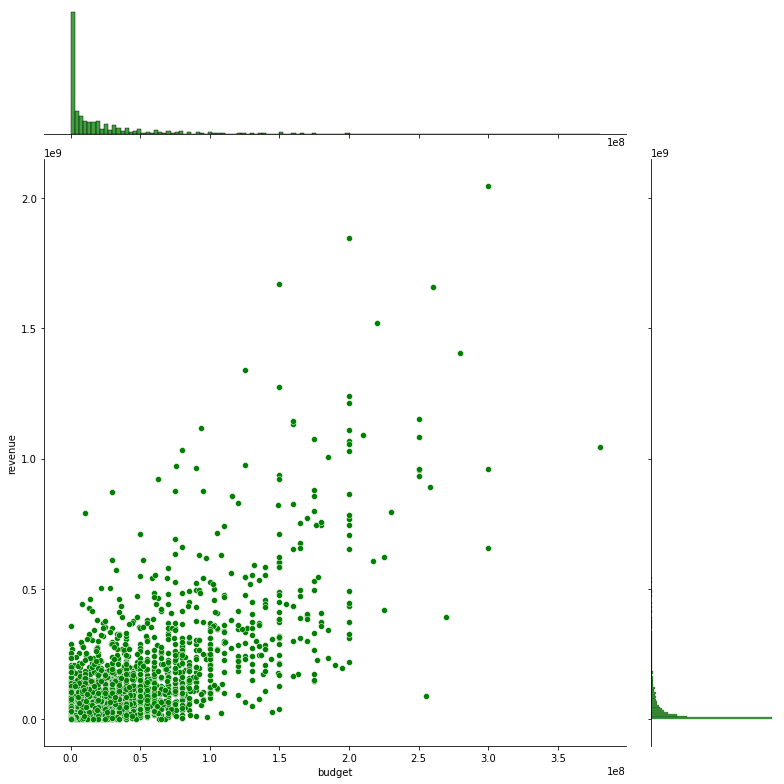

In [9]:
sns.jointplot(x="budget", y="revenue", data=df_train, height=11, ratio=4, color="g")
plt.show()